### ЗАДАНИЕ

1. Посчитать показатели Retention Rate седьмого дня и ARPPU за два периода: до и после внедрения фичи.
2. Сформировать выводы по анализу.

Импортируем необходимые модули.

In [85]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 

Начнем с данных за май. Выгрузим данные и произведем их подготовку к анализу.

Функция запроса и запись в датафрейм данных о зарегистрированных пользователях:

In [86]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       31 non-null     object
 1   registered_users_count  31 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes


Приведение типа к datatime:

In [87]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])
print("Количество зарегестрированных пользователей в мае 2019 года")
print(registered_users_count['registered_users_count'].sum())
registered_users_count.head()

Количество зарегестрированных пользователей в мае 2019 года
188943


,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266
3,2019-05-04,8639
4,2019-05-05,9787


Функция запроса и запись в датафрейм данных об активных пользователях:

In [88]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       961 non-null    object
 1   registration_date   961 non-null    object
 2   active_users_count  961 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


Приведение типов к datatime:

In [89]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


Объединим таблицы и запишем сводные данные в датафрейм.

In [90]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-05-01,2019-05-01,2590,6516
1,2019-05-02,2019-05-01,2146,6516
2,2019-05-02,2019-05-02,2049,5309
3,2019-05-03,2019-05-01,1637,6516
4,2019-05-03,2019-05-02,1817,5309


Вычисляем показатель Retention Rate, записав полученное значение в колонку retention_rate:

In [91]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249


Добавим колонку lifetime, в которой будет содержаться целое количество дней, прошедших с регистрации до даты активности.

In [92]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу

retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int32

Сформируем сводную таблицу retention_pivot:

In [93]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,...,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,...,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,...,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,...,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,...,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179
2019-05-06,0.368205,0.312260,0.227748,0.191377,0.162809,0.147732,0.137680,0.130274,0.117445,0.105806,...,0.065997,0.062029,0.060045,0.055680,0.053829,0.050919,0.049597,0.048142,0.035048,0.021690
2019-05-07,0.366349,0.326020,0.239393,0.206808,0.172770,0.153251,0.142926,0.137280,0.124859,0.113405,...,0.070657,0.062591,0.063559,0.060816,0.058235,0.057106,0.057590,0.055815,0.041781,0.028392
2019-05-08,0.393985,0.328271,0.245564,0.198195,0.176241,0.156692,0.142707,0.132782,0.121353,0.110977,...,0.066316,0.063910,0.058195,0.056842,0.053534,0.053835,0.052632,0.048872,0.038496,0.026617
2019-05-09,0.377529,0.320909,0.236777,0.205183,0.180866,0.163649,0.147497,0.136138,0.124068,0.113774,...,0.067093,0.066205,0.061945,0.060703,0.058218,0.055201,0.053958,0.054846,0.045971,0.029464


Оценим изменение Retention Rate когорт на седьмой день:

<AxesSubplot:xlabel='registration_date'>

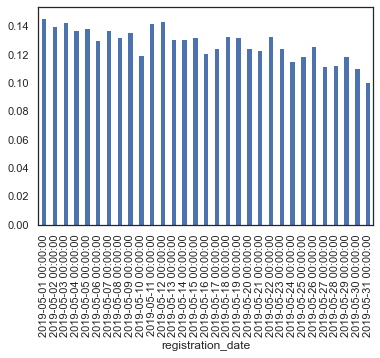

In [94]:
retention_pivot[7].plot.bar()

Найдём относительное изменение Retention Rate на седьмой день для когорты 31 мая 2019 года относительно когорты 1 мая 2019 года.

In [95]:
retention_pivot[7]['2019-05-31']/retention_pivot[7]['2019-05-01']

0.6889460885141001

Напишем запрос, который позволит получить выручку по дням в разрезе когорт для пользователей, зарегистрировавшихся в мае 2019 года. Этот запрос обернём в функцию getRevenue(), после чего получим данные по запросу и запишем в датафрейм revenue.

In [96]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue = pd.DataFrame(getRevenue())
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      912 non-null    object 
 1   registration_date         912 non-null    object 
 2   users_count_with_revenue  912 non-null    int64  
 3   revenue                   912 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6+ KB


Произведём преобразование типов к datetime.

In [97]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,1672,2357.590
1,2019-05-02,2019-05-01,1420,514.679
2,2019-05-02,2019-05-02,1367,1629.140
3,2019-05-03,2019-05-01,1048,390.952
4,2019-05-03,2019-05-02,1164,533.608


In [98]:
print("Сумма выручки, которую принесли пользователи, зарегистрировавшиеся в мае:")
print(revenue['revenue'].sum())
print("Количество пользователей, которую принесли выручку в мае:")
print(registered_users_count['registered_users_count'].sum())
print("Средняя выручку за месяц с пользователей, зарегистрировавшихся в мае:")
print(revenue['revenue'].sum()/registered_users_count['registered_users_count'].sum())
print("Средняя выручка за месяц от активного пользователя в мае:")
print(revenue['revenue'].sum()/revenue['users_count_with_revenue'].sum())

Сумма выручки, которую принесли пользователи, зарегистрировавшиеся в мае:
121998.29795000001
Количество пользователей, которую принесли выручку в мае:
188943
Средняя выручку за месяц с пользователей, зарегистрировавшихся в мае:
0.6456883713606749
Средняя выручка за месяц от активного пользователя в мае:
0.30612457926102504


Произведем аналогичные действия с данными за июнь.

Количество зарегестрированных пользователей в июне 2019 года:
100423
Относительное изменение Retention Rate на седьмой день для когорты 30 июня 2019 года относительно когорты 1 июня 2019 года:
1.3244076718481195
Изменение Retention Rate когорт на седьмой день для июня:


<AxesSubplot:xlabel='registration_date'>

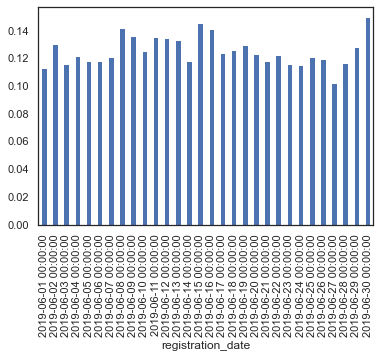

In [99]:
def getRegisteredUsersCount2():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count2 = pd.DataFrame(getRegisteredUsersCount2())
registered_users_count2['registration_date'] = pd.to_datetime(registered_users_count2['registration_date'])
print("Количество зарегестрированных пользователей в июне 2019 года:")
print(registered_users_count2['registered_users_count'].sum())


def getActiveUsersCountWithCohorts2():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts2 = pd.DataFrame(getActiveUsersCountWithCohorts2())

for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts2[col] = pd.to_datetime(active_users_count_with_cohorts2[col])
retention_table2 = active_users_count_with_cohorts2.merge(registered_users_count2,on=['registration_date'],how='left')
retention_table2['retention_rate'] = retention_table2['active_users_count'] / retention_table2['registered_users_count']
retention_table2['lifetime'] = retention_table2['activity_date'] - retention_table2['registration_date']
retention_table2['lifetime'] = retention_table2['lifetime']/np.timedelta64(1,'D')
retention_table2['lifetime'] = retention_table2['lifetime'].astype(int) # Приведем тип к целому числу

retention_pivot2 = retention_table2.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')

print("Относительное изменение Retention Rate на седьмой день для когорты 30 июня 2019 года относительно когорты 1 июня 2019 года:")
print(retention_pivot2[7]['2019-06-30']/retention_pivot2[7]['2019-06-01'])
print("Изменение Retention Rate когорт на седьмой день для июня:")
display(retention_pivot2[7].plot.bar())

In [100]:
def getRevenue2():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

revenue2 = pd.DataFrame(getRevenue2())
for col in ['date','registration_date']:
    revenue2[col] = pd.to_datetime(revenue2[col])

print("Сумма выручки, которую принесли пользователи, зарегистрировавшиеся в июне:")
print(revenue2['revenue'].sum())
print("Количество пользователей, которую принесли выручку в июне:")
print(registered_users_count2['registered_users_count'].sum())
print("Средняя выручку за месяц с пользователей, зарегистрировавшихся в июне:")
print(revenue2['revenue'].sum()/registered_users_count2['registered_users_count'].sum())
print("Средняя выручка за месяц от активного пользователя в июне:")
print(revenue2['revenue'].sum()/revenue2['users_count_with_revenue'].sum())

Сумма выручки, которую принесли пользователи, зарегистрировавшиеся в июне:
79685.874087
Количество пользователей, которую принесли выручку в июне:
100423
Средняя выручку за месяц с пользователей, зарегистрировавшихся в июне:
0.7935022264521077
Средняя выручка за месяц от активного пользователя в июне:
0.39319399242584985


### ВЫВОДЫ

Сравнив данные за май и июнь можно сказать, что изменение Retention Rate когорт на седьмой день в июне имеет вцелом положительную динамику, в отличие от мая. В числовом выражении Retention Rate когорты 30 июня 2019 года на седьмой день увеличилась на 32% относительно аналогичного показателя когорты 1 июня 2019 года. При этом мы видим, что существенно (на 47%) снизилось количество зарегистрированных в июне пользователей, что соответственно повлияло на сумму выручки от данных пользователей. Однако даное влияние уже составляет порядка -35%. Таким образом мы видим, что рост средней выручки от активного пользователя в июне снивелировал падение общей выручки. Следовательно, введенная в июне фича позволила не только остановить падение показателя вовлеченности (Retention Rate седьмого дня), но и вернуть его значение на уровень 1 мая 2019 года, а также повысить среднюю выручку за месяц от активного пользователя (ARPPU) порядка 28%. Исходя из данных можно порекомендовать увеличить привлечение новых пользователей, насколько это возможно в данной нише.